<a href="https://colab.research.google.com/github/VovaRoot/Hello-world/blob/master/hackathon_final_11_08_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Хакатон по распознаванию хот-догов. 
По мотивам крутейшего стартапа из сериала "кремниевая долина"!

https://www.youtube.com/watch?v=pqTntG1RXSY


Ваша задача: сделать революционный классификатор, который сразил большинство инвесторов и гиков из кремниевой долины не один раз!

Точнее, вам необходимо предсказать, есть на изображении хот-дог или нет. В файл с решением необходимо записать вероятность того, что на изображении **есть хот-дог**.

Качество модели будет измеряться с помощью метрики AUC-ROC, публичный лидерборд (рейтинговая таблица соревнования на платформе kaggle) будет строиться по 50% наблюдений. 

Чуть подробнее про публичный и приватный лидерборд: вам дана тестовая выборка, для которой неизвестна целевая переменная. Вы обучаете модель, предсказываете для тестовой выборки, формируете из предсказаний csv-файл, и загружаете его на платформу kaggle. Видите значение метрики AUC-ROC. Это значение называется метрикой на публичном лидерборде, и считается оно не по всем данным, а лишь по 50% от тестовой выборки. Когда соревнование заканчивается, AUC-ROC пересчитывается уже для 100% тестовой выборки, и это уже называется приватный лидерборд, он же - финальный.

Такой подход является классическим для большей части соревнований по анализу данных, и основан он на том, что если не делать такого разделения, то будет происходить неявное переобучение модели под тестовую выборку. 

На этом вводная часть заканчивается, и мы искренне желаем вам удачи :) <br>
Сможете ли вы повторить успех Jian Yuang'a? Мы в вас верим!

<hr>

Разархивируем файлы с данными и импортируем необходимые библиотеки

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:

!ls "/content/drive/My Drive"

'Colab Notebooks'      ml-20m
 data		      'Договор на проведение тренингов.gdoc'
'Google Фото'	      'Презентация_Клуб инвесторов Саши Гареева.gdoc'
 hackathon-final.zip


In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/hackathon-final.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [15]:
!ls "/tmp"

drivefs_ipc.0  drivefs_ipc.0_shell  hackathon-final.ipynb  test.zip  train.zip


In [0]:
zip_ref = zipfile.ZipFile("/tmp/test.zip", 'r')
zip_ref.extractall("/tmp/test")
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile("/tmp/train.zip", 'r')
zip_ref.extractall("/tmp/train")
zip_ref.close()

# New Section

In [0]:
import os

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
font = {
    'family': 'serif',
    'color':  'darkred',
    'weight': 'bold',
    'size': 22,
}

Загрузим данные для обучения и лидерборда

In [0]:
SEED = 257

TRAIN_DIR = '/tmp/train/train'
TEST_DIR = '/tmp/test/test'

In [0]:
categories = ['hot dog', 'not hot dog']

In [0]:
X, y = [], []

for category in categories:
    category_dir = os.path.join(TRAIN_DIR, category)
    for image_path in os.listdir(category_dir):
        X.append(imread(os.path.join(category_dir, image_path)))
        y.append(category)

Сколько у нас файлов есть для обучения?

In [28]:
len(X), len(y)

(10049, 10049)

Имеем картинки 100х100 пикселей в трех измерения (RGB - red, green, blue)

In [29]:
X[0]

array([[[0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        ...,
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ]],

       [[0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        ...,
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ]],

       [[0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        ...,
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.9647059 , 0.9647059 , 0.9647059 ]],

       ...,

       [[0.9647059 , 0.95686275, 0.96862745],
        [0.9647059 , 0.95686275, 0.96862745],
        [0.9647059 , 0

Посмотрим немного на примеры из обучающей выборки (лучше делать это сытым)

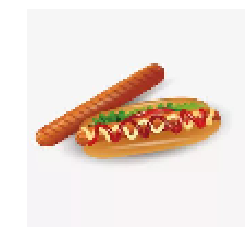

In [30]:
plt.axis("off");
plt.imshow(X[0]);

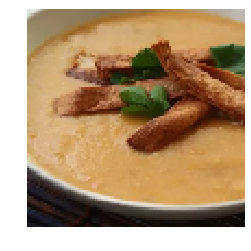

In [31]:
plt.axis("off");
plt.imshow(X[-1]);

Разделим данные на обучающую и тестовую выборки

In [0]:
y = [1 if x == 'hot dog' else 0 for x in y]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.25, random_state=SEED)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7536, 100, 100, 3), (2513, 100, 100, 3), (7536,), (2513,))

Построим очень простой классификатор, который будем считать за baseline. Преобразуем наши изображения следующим образом: для каждой картинки посчитаем среднее значение по каждому каналу (red, green, blue). Теперь в качестве признаков, описывающих объект, будет использовать просто три средних, вместо всего набора пикселей. 

In [0]:
X_train_simplify = []
X_test_simplify = []

In [0]:
for x in X_train:
    X_train_simplify.append(np.mean(x.reshape(100*100, 3), axis=0))

for x in X_test:
    X_test_simplify.append(np.mean(x.reshape(100*100, 3), axis=0))

In [0]:
X_train_simplify = np.array(X_train_simplify) 
X_test_simplify = np.array(X_test_simplify)

Получили обучающую выборку, в которой каждый объект представлен всего 3-мя признаками.

In [47]:
X_train_simplify.shape, X_test_simplify.shape

((7536, 3), (2513, 3))

Обучим модель и посмотрим на целевую метрику (ROC AUC)

In [48]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=SEED)
random_forest.fit(X_train_simplify, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=257,
                       verbose=0, warm_start=False)

In [51]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [52]:
model = Sequential()
model.add(Convolution2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', class_mode="binary", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=3)



W0812 19:38:54.997199 140035208972160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 19:38:55.049601 140035208972160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 19:38:55.077520 140035208972160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 19:38:55.082687 140035208972160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 19:38:55.148507 140035208972160 deprecation_wrappe

Epoch 1/3
7536/7536 [==============================] - 131s 17ms/step - loss: 0.3870 - acc: 0.8738
Epoch 2/3
7536/7536 [==============================] - 130s 17ms/step - loss: 0.3394 - acc: 0.8763
Epoch 3/3
7536/7536 [==============================] - 128s 17ms/step - loss: 0.3113 - acc: 0.8850


In [0]:
roc_auc_score(y_test, model.predict_proba(X_test_simplify)[:,1])

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BS = 32
IMG_SHAPE = 100
aug = ImageDataGenerator(
   featurewise_center=True,
   featurewise_std_normalization=True,
   rotation_range=20,
   width_shift_range=0.2,
   height_shift_range=0.2,
   horizontal_flip=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Convolution2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', class_mode="binary", loss='binary_crossentropy', metrics=['accuracy'])
model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
validation_data=(X_test, y_test),
steps_per_epoch=len(X_train) // BS, epochs=30)
predictions = model.predict_proba(X_test)
print('Accuracy: {}'.format(roc_auc_score(y_true=y_test, y_score=predictions)))

W0812 19:55:43.401501 140035208972160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGene

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


235/235 [==============================] - 150s 638ms/step - loss: 0.3868 - acc: 0.8528 - val_loss: 0.3991 - val_acc: 0.8794
Epoch 2/30
235/235 [==============================] - 150s 636ms/step - loss: 0.3650 - acc: 0.8720 - val_loss: 0.3712 - val_acc: 0.8794
Epoch 3/30
235/235 [==============================] - 148s 631ms/step - loss: 0.3515 - acc: 0.8764 - val_loss: 0.3450 - val_acc: 0.8802
Epoch 4/30
235/235 [==============================] - 151s 642ms/step - loss: 0.3359 - acc: 0.8755 - val_loss: 0.3083 - val_acc: 0.8862
Epoch 5/30
235/235 [==============================] - 151s 642ms/step - loss: 0.3191 - acc: 0.8878 - val_loss: 0.2799 - val_acc: 0.8965
Epoch 6/30
235/235 [==============================] - 150s 638ms/step - loss: 0.3093 - acc: 0.8857 - val_loss: 0.2584 - val_acc: 0.9105
Epoch 7/30
235/235 [==============================] - 149s 634ms/step - loss: 0.3017 - acc: 0.8924 - val_loss: 0.3256 - val_acc: 0.8945
Epoch 8/30
235/235 [==============================] - 149s 

### Сформируем файл с предсказаниями

In [0]:
leaderboard_X = []
leaderboard_filenames = []

In [0]:
for image_path in os.listdir(TEST_DIR):
    leaderboard_X.append(imread(os.path.join(TEST_DIR, image_path)))
    leaderboard_filenames.append(image_path)

Глянем, что тут у нас вкусного в выборке для leaderboard?

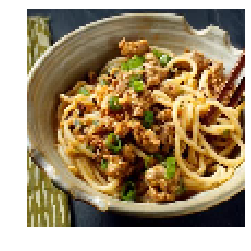

In [40]:
plt.axis("off");
plt.imshow(leaderboard_X[0]);

In [41]:
print(leaderboard_X[0].shape, leaderboard_filenames[0])

(100, 100, 3) 05ec587ca98cc4396ca1bdc2267feaa807c345325294d4f11caca3bdadddde27.png


In [42]:
leadeboard_predictions = []

for x in leaderboard_X:
    leadeboard_predictions.append(
        random_forest.predict_proba([np.mean(x.reshape(100*100, 3), axis=0)])[:,1][0]
    )

NameError: ignored

Посмотрим, как бы работало наше приложение :)<br>
Вы можете менять значение переменной ```idx```, и смотреть, что предсказывает модель на различных изображениях.

IndexError: ignored

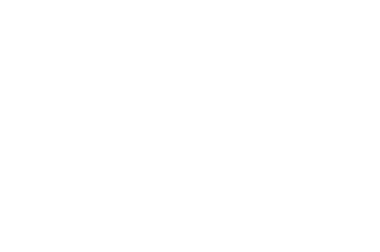

In [43]:
idx = 520

plt.axis("off");
if leadeboard_predictions[idx] > 0.5:
    plt.text(20, -5, 'HOT DOG!!!', fontdict=font)
else:
    plt.text(15, -5,'not hot dog...', fontdict=font)
plt.imshow(leaderboard_X[idx]);

Формируем DataFrame, содержащий наше решение

In [0]:
submission = pd.DataFrame(
    {
        'image_id': leaderboard_filenames, 
        'image_hot_dog_probability': leadeboard_predictions
    }
)

In [0]:
submission.head()

Сохраним результат в submit.csv, который нужно отправить на kaggle. Сделайте это!

Ссылку на соревнование вы можете получить у своего куратора. 

In [0]:
submission.to_csv('submit.csv', index=False)

### Идеи для развития и улучшения модели!

1. Попробуйте в качестве модели сверточную нейронную сеть: экспериментируйте с архитектурами, алгоритмами оптимизации. 
2. Сделайте аугментацию (data augmentation) обучающей выборки. 
3. Найдите больше данных и используйте их для обучения модели! Только не забывайте о том, что распределение классов hot-dog \ not hot-dog должно оставаться на прежнем уровне. 
4. Используйте технику transfer learning: ее идея заключается в дообучении на ваших данных модели, хорошо работающей на каком-либо датасете (в изображениях это обычно ImageNet). Стоит обратить внимание на модели семейства ResNet. 
5. Посмотрите в сторону блендинга (blending) - это способ, позволяющий объединить предсказания нескольких моделей, что в результате может вам дать более устойчивый классификатор

In [0]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Convolution2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Convolution2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', class_mode="binary", loss='binary_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, batch_size=32, epochs=3)

W0810 13:10:47.568066 4351292864 deprecation_wrapper.py:119] From /Users/mac/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0810 13:10:47.587442 4351292864 deprecation_wrapper.py:119] From /Users/mac/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0810 13:10:47.886719 4351292864 deprecation_wrapper.py:119] From /Users/mac/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0810 13:10:47.925137 4351292864 deprecation_wrapper.py:119] From /Users/mac/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0810 13:10:47.93676

Epoch 1/3
7536/7536 [==============================] - 89s 12ms/step - loss: 0.3674 - acc: 0.8755
Epoch 2/3
7536/7536 [==============================] - 88s 12ms/step - loss: 0.3356 - acc: 0.8799
Epoch 3/3
7536/7536 [==============================] - 84s 11ms/step - loss: 0.3120 - acc: 0.8884


In [0]:
for idx, img in enumerate(X_test):
    if y_test[idx] == 1:
        plt.imsave(f'validation/hot dog/{idx}', img)
    else:
         plt.imsave(f'validation/not hot dog/{idx}', img)
            
for idx, img in enumerate(X_train):
    if y_train[idx] == 1:
        plt.imsave(f'training/hot dog/{idx}', img)
    else:
         plt.imsave(f'training/not hot dog/{idx}', img)

In [0]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'training',  # this is the target directory
        target_size=(100, 100),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'validation',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='binary')

Found 7536 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [0]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Epoch 1/50
125/125 [==============================] - 28s 227ms/step - loss: 0.4676 - acc: 0.8535 - val_loss: 0.4074 - val_acc: 0.8700
Epoch 2/50
125/125 [==============================] - 28s 224ms/step - loss: 0.3843 - acc: 0.8780 - val_loss: 0.3405 - val_acc: 0.8838
Epoch 3/50
125/125 [==============================] - 28s 228ms/step - loss: 0.3750 - acc: 0.8740 - val_loss: 0.3502 - val_acc: 0.8788
Epoch 4/50
125/125 [==============================] - 31s 245ms/step - loss: 0.3750 - acc: 0.8725 - val_loss: 0.3462 - val_acc: 0.8815
Epoch 5/50
125/125 [==============================] - 28s 224ms/step - loss: 0.3687 - acc: 0.8660 - val_loss: 0.3079 - val_acc: 0.8800
Epoch 6/50
125/125 [==============================] - 30s 239ms/step - loss: 0.3330 - acc: 0.8770 - val_loss: 0.2831 - val_acc: 0.8975
Epoch 7/50
125/125 [==============================] - 30s 244ms/step - loss: 0.3247 - acc: 0.8870 - val_loss: 0.3348 - val_acc: 0.8752
Epoch 8/50
125/125 [==============================] - 3